### Gathering Insights from airbnb city data for Seattle using Data science and Machine Learning



#### Get the required packages

In [1]:
# The anaconda environment used here comes with python 3.6 and all the necessary packages installed except for basemap which
# needs to be installed and scikit-learn which needs to be updated to v0.21

import os

# import functions module
from functions import *

# Data retrival and handling packages
import pandas as pd
import pandas_profiling
import numpy as np

# Data visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap
import statsmodels.api as sm

# Get scikit learn tools for machine learning
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

%matplotlib inline
sns.set(style='ticks')

import warnings
warnings.filterwarnings('ignore')

#### Fetch airbnb city data from the local repository


In [2]:
# get calendar and listings data
calendar = get_airbnb_data('seattle', 'calendar')
listings = get_airbnb_data('seattle', 'listings')

calendar.sample(5)

,listing_id,date,available,price
678853,5652705,2016-11-17,t,$125.00
671426,8116504,2016-07-13,t,$100.00
833461,674113,2016-06-18,t,$42.00
114098,9241055,2016-08-09,f,NaN
333854,4256705,2016-09-04,t,$125.00


In [3]:
listings.sample(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
324,4122325,https://www.airbnb.com/rooms/4122325,20160104002432,2016-01-04,Spacious 3bd/2ba Green Lake Home,Our comfortable and stylish home is a short wa...,Our home has an open floor plan on the main fl...,Our comfortable and stylish home is a short wa...,none,Green Lake is a beautiful neighborhood in the ...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,1,1.79
1341,7264667,https://www.airbnb.com/rooms/7264667,20160104002432,2016-01-04,Modern Urban Loft Downtown Seattle,"Minimalist 1 bedroom loft style apartment, exp...","Hand troweled concrete floors, 15' ceilings, e...","Minimalist 1 bedroom loft style apartment, exp...",none,Located in Denny Triangle you can walk to Paci...,...,9.0,f,NaN,WASHINGTON,t,strict,f,f,1,1.28
1353,8027776,https://www.airbnb.com/rooms/8027776,20160104002432,2016-01-04,Beautiful & clean downtown studio,Entire/Private apartment Walk everywhere/10 mi...,NaN,Entire/Private apartment Walk everywhere/10 mi...,none,NaN,...,10.0,f,NaN,WASHINGTON,t,strict,f,f,3,9.08
208,7021544,https://www.airbnb.com/rooms/7021544,20160104002432,2016-01-04,Between Fremont & Downtown! Retro,Turn right & a 10 minute walk takes you to din...,This is a vintage flat in a classic building i...,Turn right & a 10 minute walk takes you to din...,none,This is the real reason you should be consider...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,5,3.15
583,8069192,https://www.airbnb.com/rooms/8069192,20160104002432,2016-01-04,Brand New Madison Valley Townhome,Room available to rent in brand new Madison Va...,Brand new green build townhouse. Bedroom is sp...,Room available to rent in brand new Madison Va...,none,Madison Valley is known as the Paris of Seattl...,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN


#### Format Calendar data 



In [4]:
# convert date to pandas datetime format
calendar['date'] = to_date_time(calendar.date)

# convert price to type float
calendar['price'] = to_numeric(calendar.price)

calendar.sample(5)

,listing_id,date,available,price
893786,6218849,2016-09-26,f,NaN
327660,7748905,2016-09-15,t,82.0
627553,9813684,2016-05-01,t,45.0
851892,136480,2016-12-16,t,65.0
1074536,9094872,2016-12-10,t,99.0


#### Visualize pricing trends in relation to time of year

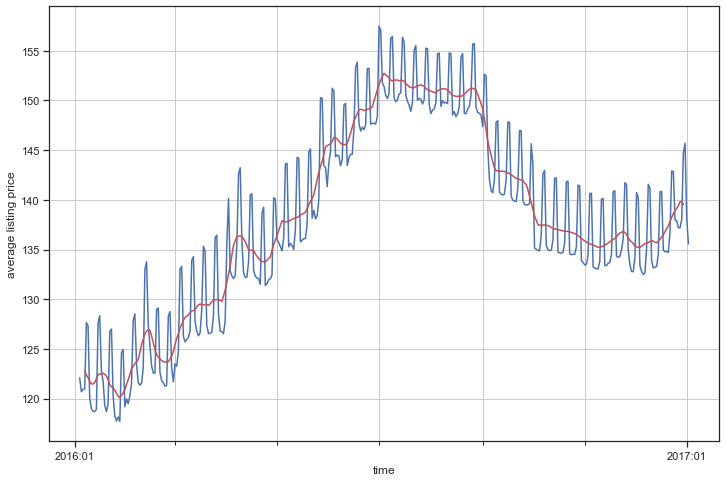

In [5]:
# for each date, calculate mean price over all available property listings
df = pd.DataFrame(calendar.groupby('date')['price'].mean())

# decompose observed time series into its 3 components: trend, seasonality and noise
decomposition = sm.tsa.seasonal_decompose(df, model='additive')    #price = Level + Trend + Seasonality + Noise

# plot oberved time series of property prices
plot_time_series(df.index, df.price)

# plot price trend
plt.plot(decomposition.trend.index, decomposition.trend, "-r")

plt.show()

#### Clean and format listings data

In [6]:
# Take a detailed look at the features for feature selection later
pandas_profiling.ProfileReport(listings)

Number of variables,92
Number of observations,3818
Total Missing (%),8.5%
Total size in memory,2.7 MiB
Average record size in memory,736.0 B
Numeric,25
Categorical,51
Boolean,0
Date,0
Text (Unique),2
Rejected,14


In [7]:
# Ignore features with (1) high cardinality, (2) constant value, (3) high skewness, (4) lot of missing data and
# (5) very high corelation with another feature
# also ignore features with no relation to price whatsoever (listing id, calendar last scraped etc)

num_cols = ['latitude','longitude','accommodates',
            'bathrooms', 'bedrooms', 'beds', 'price','number_of_reviews',
            'reviews_per_month', 'availability_365', 'guests_included']

cat_cols = ['host_response_time', 'host_is_superhost', 'host_identity_verified',
            'neighbourhood_group_cleansed', 'property_type', 'room_type',
            'instant_bookable', 'cancellation_policy']

listings = listings[num_cols+cat_cols]

# get pricing data from the calendar dataset
listings['price'] = calendar.groupby('listing_id', sort=False, as_index=False)['price'].mean().drop('listing_id', axis=1)

listings.sample(5)

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,reviews_per_month,availability_365,guests_included,host_response_time,host_is_superhost,host_identity_verified,neighbourhood_group_cleansed,property_type,room_type,instant_bookable,cancellation_policy
657,47.614958,-122.289126,7,1.5,0.0,2.0,158.349057,1,0.68,106,7,within a day,f,t,Central Area,Townhouse,Entire home/apt,f,strict
2120,47.572489,-122.311165,2,1.0,1.0,1.0,60.000000,3,0.75,365,1,within a few hours,f,f,Beacon Hill,House,Private room,f,flexible
1973,47.691093,-122.364640,1,2.5,1.0,1.0,50.000000,0,NaN,338,1,within a few hours,f,t,Other neighborhoods,House,Private room,f,moderate
346,47.665214,-122.336753,6,1.0,2.0,3.0,161.986301,45,1.58,365,2,within a day,f,t,Other neighborhoods,House,Entire home/apt,f,strict
1742,47.573999,-122.411470,8,1.5,3.0,5.0,295.554217,0,NaN,332,1,within a day,f,t,West Seattle,House,Entire home/apt,f,strict


#### Analyze Feature corelations

For a complete correlation matrix with numerical and categorical features, numerical features have to be converted to type object. Discretization of numerical features by binning them into unique categories is done here. Phi coefficient is calculated for each binary combination of features giving a nxn matrix, where n is the number of features. A heat map is constructed.


In [8]:
# copy 'listings' dataset for analysis
df = listings.copy()

all_cols = num_cols+cat_cols

# discretize numerical features for numerical-categorical corelation calculations
for col in num_cols:
    df[col] = pd.qcut(df[col], 10, duplicates='drop')
    df[col] = df[col].astype(str).values

# convert categorical features to type 'categorical' for faster evaluations
for col in cat_cols:
    df[col] = df[col].astype('category')

# make empty n x n array and populate it with phi coefficients calculated
# using the get_phi_score function from the functions module. Set max coefficient to 1.0
phi_coeff = np.empty((len(all_cols), len(all_cols)))
for i in range(len(all_cols)):
    for j in range(len(all_cols)):
        if i==j:
            phi_coeff[i,j]=1.0
        else:
            conf_matrix = pd.crosstab(df[all_cols[i]], df[all_cols[j]])
            phi_coeff[i,j] = get_phi_score(conf_matrix)
            if phi_coeff[i,j]>1.0:
                phi_coeff[i,j]=1.0

corr = pd.DataFrame(phi_coeff, columns=all_cols, index=all_cols)

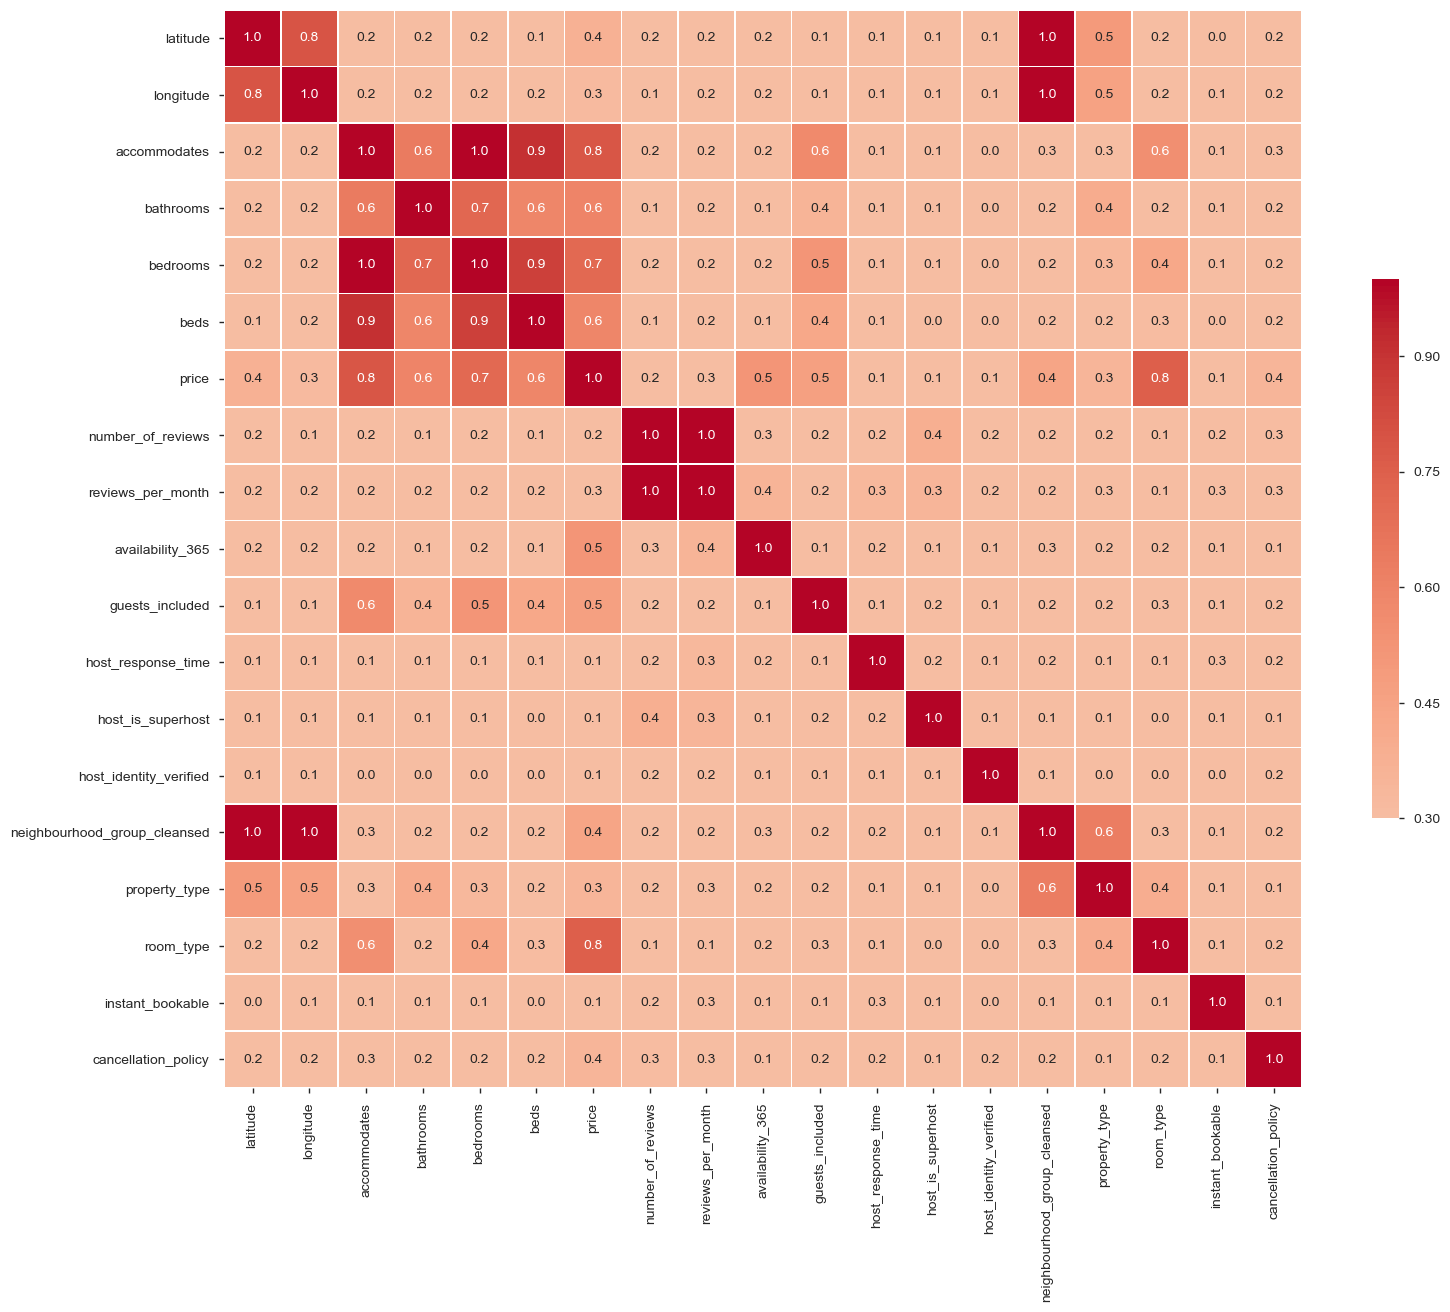

In [9]:
g = sns.heatmap(corr, vmin=0.3, vmax=1.0, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.1f', cmap='coolwarm')
sns.despine()

g.figure.set_size_inches(18,14)

plt.show()

#### Pearson correlation coefficent for numerical features

The heatmap above shows feature correlations in a concise manner. However, type change from numeric to categorical for numerical features results in loss of information and interpretability. For numerical features only, pearson coefficients give a more interpretable result. +1 means perfect positive correlation and -1 means perfect negative correlation

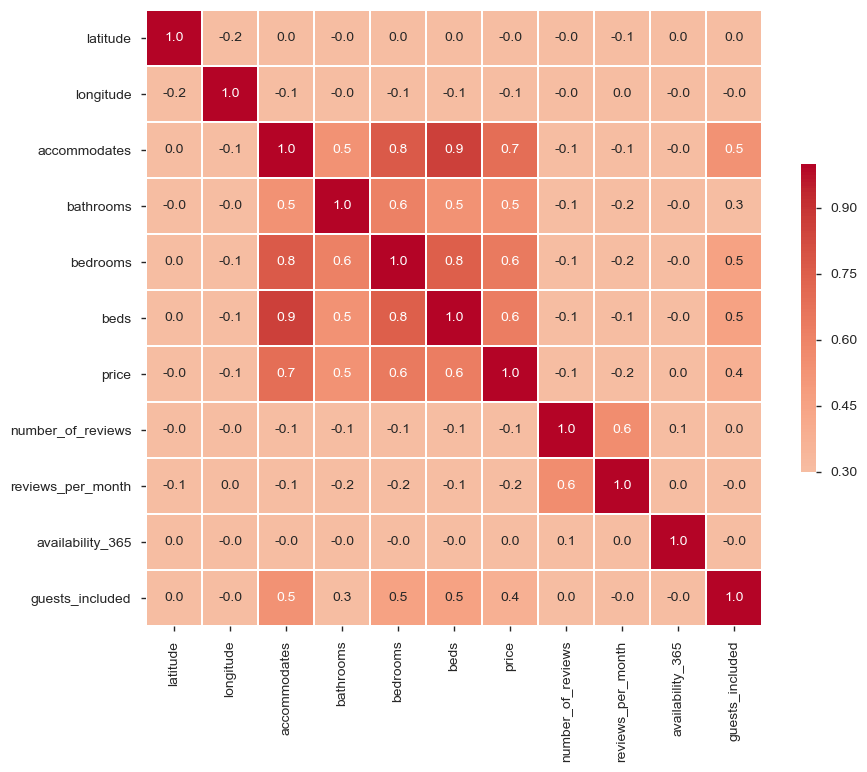

In [10]:
corr = listings.corr()
g = sns.heatmap(corr, vmin=0.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.1f', cmap='coolwarm')
sns.despine()

g.figure.set_size_inches(10,8)

plt.show()

#### Visualize correlations of features most related to price

Correlation data from the heatmaps is used to single out features strongly related to price. A pairplot is constructed for a more detailed insight into these strong correlations

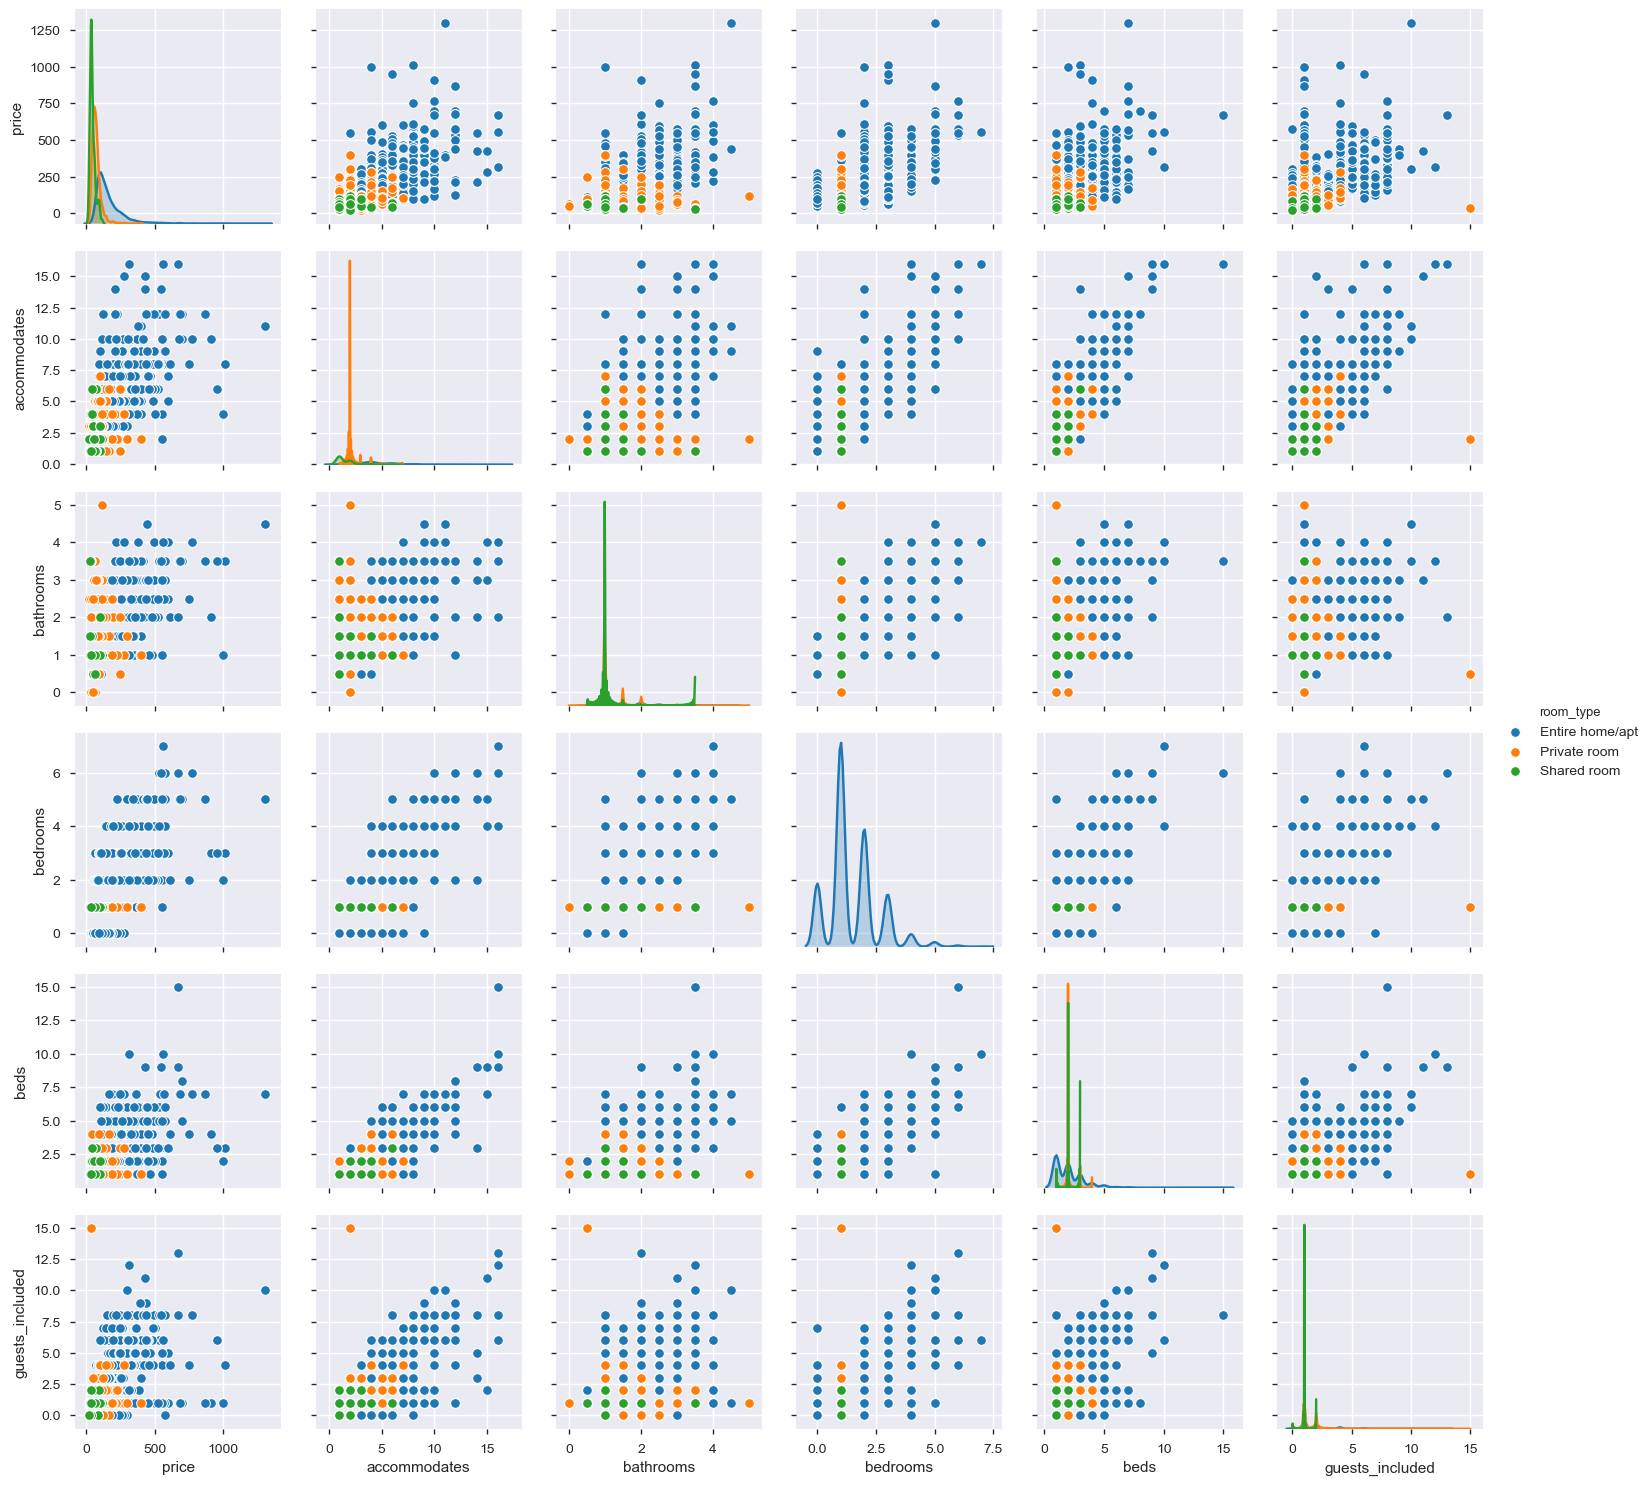

<Figure size 1200x1000 with 0 Axes>

In [11]:
filtered_listings = listings[listings['property_type'].isin(['House', 'Apartment', 'Condominium', 'Townhouse'])].copy()

g = sns.pairplot(filtered_listings[['price', 'accommodates', 'bathrooms',
                           'bedrooms', 'beds', 'guests_included', 'room_type']], hue='room_type')
sns.despine()
plt.figure(figsize=(12,10))
plt.show()

#### Analyze correlation between price and neighboorhood

Construct a pair plot to visualize relationship between neighbourhood, property type and property price

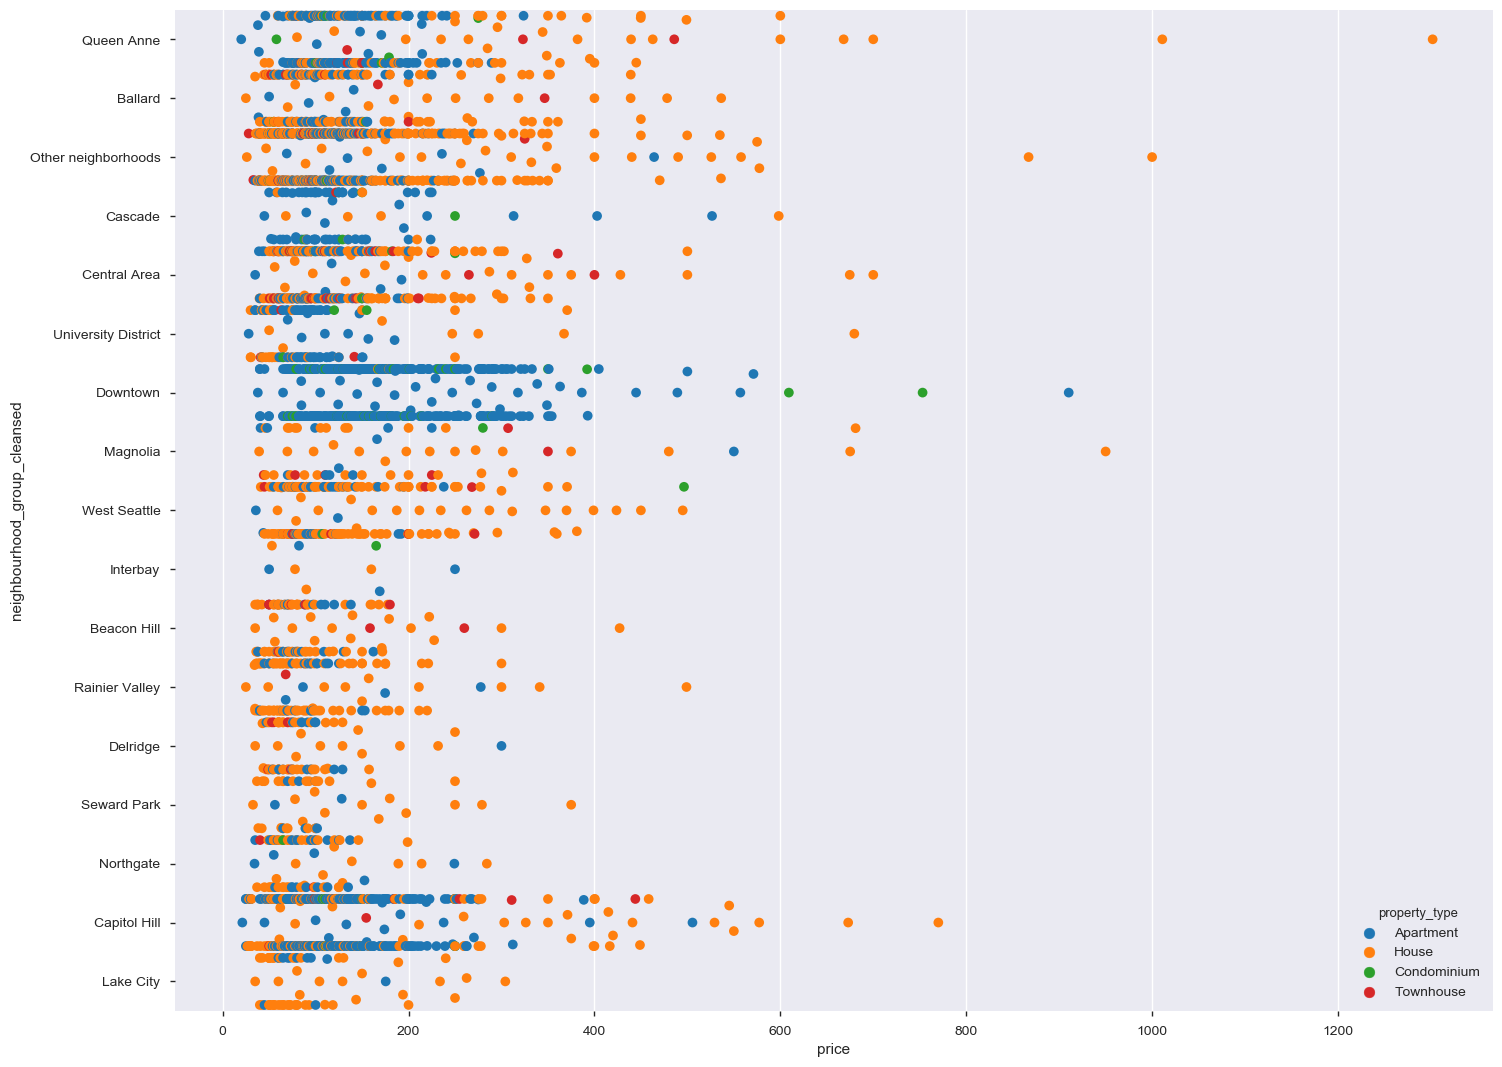

In [12]:
g = sns.swarmplot(y='neighbourhood_group_cleansed',
                 x='price',
                  hue='property_type',
                 data=filtered_listings,
                 size=7)
sns.despine()
g.figure.set_size_inches(17,13)
plt.show()

#### Visualize property price variation in relation to location

Create a base geographical plot of Seattle and draw country and county lines to create the map. Populate the map with property listings using a scatter plot. Set point size to reflect accommodates available in a listing.

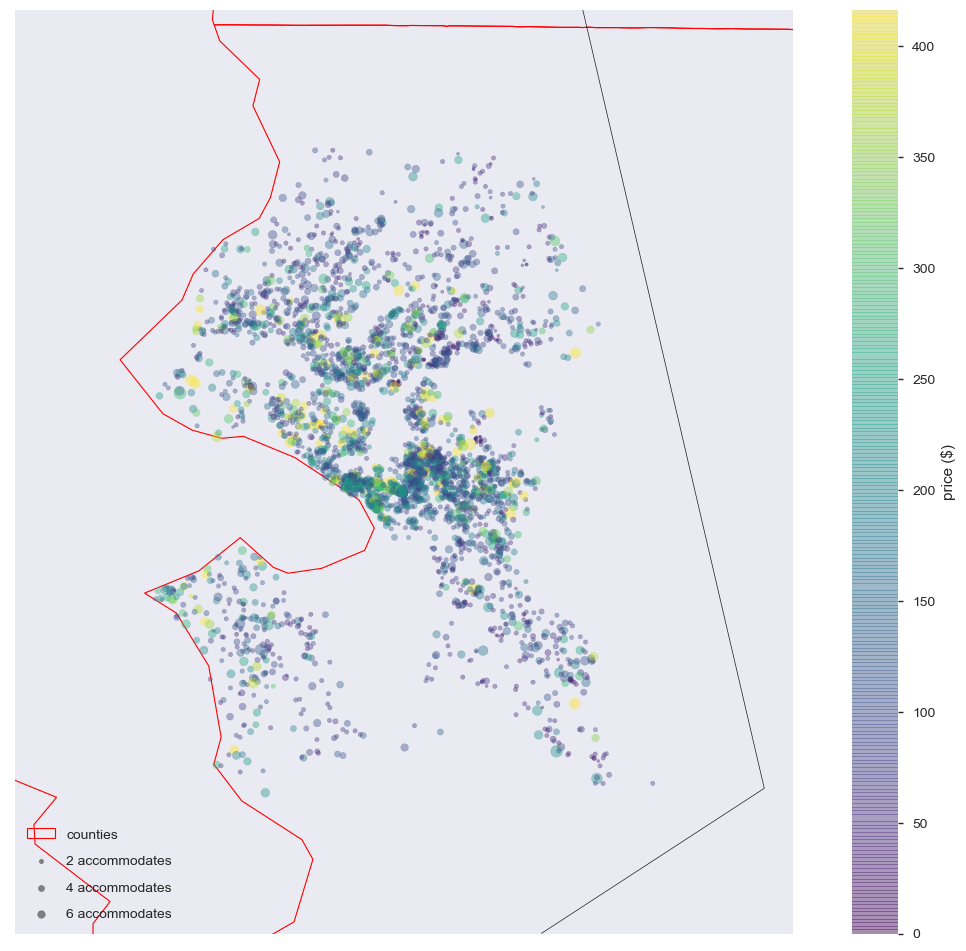

In [13]:
df = filtered_listings[['latitude', 'longitude', 'price', 'accommodates']].copy()

df.dropna(axis=0, inplace=True)

latitudes = df.latitude
longitudes = df.longitude
price_distribution = df.price
accommodation_distribution = df.accommodates

plot_geographical(latitudes, longitudes, price_distribution, accommodation_distribution)

#### Prepare data for machine learning pipelines

Create train and test sets. Cap y train (prices) at the 99th quantile. This will increase bias but should decrease variance.

In [14]:
listings_ml = listings.dropna(subset=['price'], axis=0)

X = listings_ml.drop('price', axis=1)
y = listings_ml['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

upper_limit = y_train.quantile(0.99)
lower_limit = y_train.quantile(0.01)

is_over_limit = y_train > upper_limit
is_under_limit = y_train < lower_limit

y_train[is_over_limit] = upper_limit
y_train[is_under_limit] = lower_limit

#### Predict listing prices

Transform the X_train and X_test data by:
- transforming categorical and numerical data seperately
- imputing missing values and binary encoding for the categorical data, and
- imputing missing values and scaling for the numerical data

Fit three independent predictor models on the transformed training data.
Select model with best cross validation and fit score

Evaluate the best model fit

In [15]:
num_cols = ['latitude','longitude','accommodates',
            'bathrooms', 'bedrooms', 'beds','number_of_reviews',
            'reviews_per_month', 'availability_365', 'guests_included']

cat_cols = ['host_response_time', 'host_is_superhost', 'host_identity_verified',
            'neighbourhood_group_cleansed', 'property_type', 'room_type',
            'instant_bookable', 'cancellation_policy', 'host_identity_verified']

cat_pipeline = Pipeline([
    ('si', SimpleImputer(strategy='constant', fill_value='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

num_pipeline = Pipeline([
    ('si', SimpleImputer(strategy='mean')),
    ('ss', StandardScaler())
])

transformers = [('cat', cat_pipeline, cat_cols),
                ('num', num_pipeline, num_cols)]

ct = ColumnTransformer(transformers=transformers)


X_train_prepared = ct.fit_transform(X_train)
X_test_prepared = ct.transform(X_test)

lin_reg = LinearRegression()
svm_reg = SVR()
rnd_reg = RandomForestRegressor()

cv_scores = []
fit_score = []
for model in (lin_reg, svm_reg, rnd_reg):
    model.fit(X_train_prepared, y_train)
    cv_score = cross_val_score(model, X_train_prepared, y_train, cv=3, scoring='neg_mean_squared_error')
    cv_scores.append(np.sqrt(-cv_score.mean()))
    fit_score.append(model.score(X_train_prepared, y_train))
    
print('linear model - cv: ', cv_scores[0], ' fit: ', fit_score[0] )
print('support vector machine - cv: ', cv_scores[1], ' fit: ', fit_score[1])
print('random forrest regressor - cv: ', cv_scores[2], ' fit: ', fit_score[2])

linear model - cv:  462299160722.5021  fit:  0.7000000702161875
support vector machine - cv:  68.57298555580287  fit:  0.4605533164031384
random forrest regressor - cv:  49.48102925904909  fit:  0.9489627690734085


In [16]:
param_grid = [
    {'n_estimators': [80, 120, 160, 200], 'max_features': [0.1, 0.15, 0.20, 0.25, 0.40], 'bootstrap':[True], 'n_jobs':[-1]},
  ]

grid_search_cv = GridSearchCV(RandomForestRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')

grid_search_cv.fit(X_train_prepared, y_train)
bst_estm = grid_search_cv.best_estimator_
y_pred = bst_estm.predict(X_test_prepared)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

59.615493784519124

#### Analyze feature importances: which features best help predict property price?

RandomForrestRegressor's feature importance method is called to display feature importances

In [17]:
features = np.concatenate((ct.named_transformers_['cat'].named_steps['ohe'].get_feature_names(), num_cols))
feature_importances = bst_estm.feature_importances_
importances = pd.DataFrame({'features':features, 'importances':feature_importances}).sort_values('importances', ascending=False).reset_index(drop=True).head(n=15)
importances.head(15)

,features,importances
0,bedrooms,0.167421
1,accommodates,0.149817
2,bathrooms,0.108142
3,beds,0.090469
4,x5_Entire home/apt,0.059693
5,latitude,0.052845
6,reviews_per_month,0.045573
7,longitude,0.042186
8,availability_365,0.039599
9,x5_Private room,0.035062
